In [54]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial

In [55]:
def u0(x):
    """initial condition"""
    u = -torch.sin(torch.pi * x)
    return u

class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(2, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 1)
        
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        activation = nn.Tanh()
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

# Create a model

Create a model for
$$
u_t + u u_x = 0
$$
with $u(x,0)=-sin(\pi x)$ and $u(-1,t)=u(1,t)=0$.

In [56]:
# 1. FIXME -- training data
nx_train = 100
nt_train = 100
x1d = torch.linspace(-1,1, nx_train, requires_grad=True)
t1d = torch.linspace(0, 0.5, nt_train, requires_grad=True)

x_m, t_m = torch.meshgrid(x1d, t1d)
x_bc = x1d.reshape(-1, 1)
t_bc = t1d.reshape(-1, 1)
x = x_m.reshape(-1, 1)
t = t_m.reshape(-1, 1)

# 2. set the model
torch.manual_seed(23939)
model = ffnn(15, 2)

# 3. set the optimizer
lr = 0.025
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 10000
loss_history = []

# 4. FIXME -- set the loss for BC, IC, and the residual
def loss_function(model, x, t, x_bc, t_bc): 
    u_ic = u0(x_bc)
    t1d0 = torch.zeros_like(x_bc)
    loss_ic = model(x_bc, t1d0) - u_ic

    loss_bc_left = model(-torch.ones_like(t1d0), t1d0)
    loss_bc_right = model(torch.ones_like(t1d0), t1d0)

    u = model(x,t)   
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(t), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    # u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(x), create_graph=True)
    loss_res = torch.pow((u_t + u*u_x),2).mean()

    loss_value = loss_ic.pow(2).mean() + \
                 loss_bc_left.pow(2).mean() + \
                 loss_bc_right.pow(2).mean() + \
                 loss_res.pow(2).mean()
    return loss_value

In [57]:
for i in range(n_epochs):

    loss = loss_function(model, x, t, x_bc, t_bc)
    opt.zero_grad()
    loss_history.append(loss.item())
    
    loss.backward()
    opt.step()

    if i % 1000 == 0:
        print(f'epoch {i}, loss = {loss}')

epoch 0, loss = 0.7027519941329956
epoch 1000, loss = 0.009511332027614117
epoch 2000, loss = 0.006827174685895443
epoch 3000, loss = 0.005982702597975731
epoch 4000, loss = 0.012286013923585415
epoch 5000, loss = 0.004438779316842556
epoch 6000, loss = 0.004374915733933449
epoch 7000, loss = 0.007044759579002857
epoch 8000, loss = 0.0389784574508667
epoch 9000, loss = 0.0053634606301784515


# Plot the solution

Text(0.5, 1.0, 'Fit on initial condition')

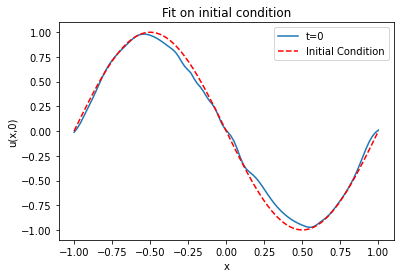

In [58]:
x_ = x_bc.detach().numpy()
y_ = model(x_bc, torch.zeros_like(x_bc)).detach().numpy()
%matplotlib inline
plt.plot(x_, y_,label='t=0')
plt.plot(x_,u0(x_bc).detach().numpy(),'--r',label="Initial Condition")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.legend()
plt.title("Fit on initial condition")

Text(0.5, 1.0, 'Training Loss')

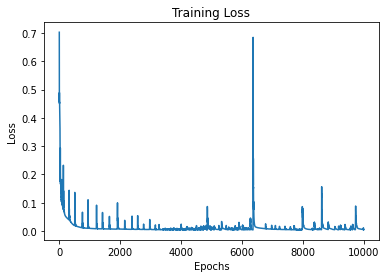

In [59]:
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")

Text(0.5, 1.0, 'Hotmap')

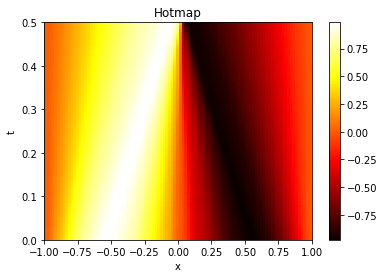

In [60]:
mag = model(x, t).reshape(100, 100).detach().numpy()
plt.ioff()
fig = plt.gcf()
ax = plt.gca()
im = ax.pcolormesh(x_m.detach().numpy(), t_m.detach().numpy(), mag, cmap='hot')
fig.colorbar(im, ax=ax)
plt.xlabel("x")
plt.ylabel("t")
plt.title("Hotmap")